# Introduction

In [2]:
import os
# path
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = os.getcwd()+"/drive/MyDrive/samples/Aimoz"
except:
    from pathlib import Path
    # 현재 위치가 Aimoz/program/FCN_train/train_pks.ipynb 일 경우, parent는 3번
    path = Path(os.path.realpath(__file__)).parent.parent.parent
  
print(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/samples/Aimoz


In [3]:
# Aimoz

# Function Definition (Load, Visualizer, Model, Run, Demo)

In [4]:
# Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import librosa
import librosa.display

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import os 
import pickle
import gzip

In [5]:
# Load Data from file 
def LD_NameList(folder_path):
    file_list = os.listdir(folder_path)
    name_list = [i[:-4] for i in file_list if i.endswith(".wav")]
    print(name_list)
    return name_list

def LD_MakeSTFT(name, folder_path, n_fft, hop_length):
    wav = librosa.load(folder_path+name+".wav", None)[0]
    S = librosa.stft(wav, n_fft, hop_length, n_fft)
    log_S = librosa.power_to_db(S**2, ref=np.max)
    return log_S


def LD_MakeLabel(name, folder_path, label_size, hop_length, fs):
    # abstract data from file
    ticks_per_beat, tempo_info, piano_info = LD_GetLabelData(name, folder_path, label_size)
    print(f"piano track: {list(piano_info.keys())}")
    print(f"real time: {hop_length / fs * label_size}")
    print(f"calc time: {LD_TimeUpdate(tempo_info, ticks_per_beat, tempo_info[-1][0], 0)}")
    if not piano_info:
        print(f"no piano in {name}")
        return []

    # make label via data
    label = np.zeros((label_size, 131))
    stft_gap = hop_length / fs  # stft 한 조각당 시간
    # make each label and merge
    for track, each_piano in piano_info.items():
        each_label = np.zeros((label_size, 131))
        velocity = np.zeros(131)  # velocity[pitch] = velocity 값, 0이면 현재 없는 것
        time, tick_prev, label_idx = 0, 0, 0  # 각각의 piano마다 새로 초기화 됨
        # make each label
        for tick_now, pitch, v in each_piano:
            time += LD_TimeUpdate(tempo_info, ticks_per_beat, tick_now, tick_prev)
            while label_idx * stft_gap < time:  # label_idx*stft_gap은 label의 time이다. label의 time이 실제시간을 넘어서지 않았다면 업데이트
                each_label[label_idx] = velocity.copy()
                label_idx += 1
            # velocity[pitch] = v # velocity 로 처리
            velocity[pitch] = 1 if v > 0 else 0  # 1 or 0 으로 처리
            tick_prev = tick_now
        # 0이 아닌(꺼지지 않은) 노트가 존재할 때
        if velocity.sum() > 0:
            print(f"{name} has non-zero velocity at track{track}")
        # merge
        for i in range(label_size):
            label[i] = np.logical_or(label[i], each_label[i])
    return label

def LD_GetLabelData(name, folder_path, label_size):
    ticks_per_beat, tempo_info, piano_info = 0, [], {}
    piano_list = [0]  # instrument 번호
    max_tick = 0
    with open(f"{folder_path}{name}.csv", "r") as f:
        rdr = csv.reader(f)
        ch_inst = {}
        for line in rdr:
            tick, command = int(line[1]), line[2]
            if command in [" Note_on_c", " Note_off_c"]:
                track, ch, pitch, velocity = int(line[0]), int(line[3]), int(line[4]), int(line[5])
                if track not in piano_info:
                    piano_info[track] = []
                if ch != 9 and ch_inst[ch] in piano_list:
                    if command == " Note_off_c":
                        velocity = 0
                    piano_info[track].append([tick, pitch, velocity])
            elif command == " Program_c":
                ch, instrument = int(line[3]), int(line[4])
                ch_inst[ch] = instrument
            elif command == " End_track":
                max_tick = max(max_tick, tick)
            elif command == " Tempo":
                tempo = int(line[3])
                tempo_info.append([tick, tempo])
            elif command == " Header":
                ticks_per_beat = int(line[5])
    if len(tempo_info) == 0:
        tempo_info.append([0, 120])  # base tempo = 120
    tempo_info.append([max_tick + 1, 0])  # [tick,tempo]: tick부터 tempo
    not_piano_track = []
    for track in piano_info:
        if len(piano_info[track]) == 0:
            not_piano_track.append(track)
    for track in not_piano_track:
        del piano_info[track]
    return ticks_per_beat, tempo_info, piano_info


def LD_TimeUpdate(tempo_info, ticks_per_beat, tick_now, tick_prev):
    # find tempo
    tempo_now, tempo_idx = 0, 0
    for i in range(len(tempo_info)):
        tick, tempo = tempo_info[i]
        if tick_prev >= tick:
            tempo_now = tempo
            tempo_idx = i
    # calc time
    time = 0
    while True:
        if tick_prev == tick_now:
            break
        tempo_change_tick = tempo_info[tempo_idx + 1][0]
        tick = min(tick_now, tempo_change_tick)  # now로 가기 전에 tempo가 변한다면, 변하는 부분까지만 계산
        time += (tick - tick_prev) * tempo_now / (10**6) / ticks_per_beat
        tick_prev = tick
        tempo_now = tempo_info[tempo_idx + 1][1]
        tempo_idx += 1
    return time


def LD_MakeData(folder_path, n_fft, hop_length, fs):
    name_list = LD_NameList(folder_path)
    ld_STFTs, ld_labels = [], []
    for name in name_list:
        print(f"make {name}")
        tmp_STFT = np.transpose(LD_MakeSTFT(name, folder_path, n_fft, hop_length))
        tmp_label = LD_MakeLabel(name, folder_path, tmp_STFT.shape[0], hop_length, fs)
        if len(tmp_label) > 0:
            ld_STFTs.append(tmp_STFT)
            ld_labels.append(tmp_label)
        if ld_STFTs[-1].shape[0] != len(ld_labels[-1]):
            print(f"LOAD: size error in {name}")
    return ld_STFTs, ld_labels




In [6]:
# Visualizer
def VI_concatentate(input_):
    return np.concatenate(input_)

def VI_testResult(data_loaders,test_result,title_,cmap=plt.cm.Blues):
    print(test_result[:2])
    input_nd = np.array(test_result[-1])>0

    train_loader = data_loaders[-1] 
    label_list = []
    for x,t in train_loader: 
        label_list += t.detach().cpu().numpy().tolist()
    label_nd = np.array(label_list)>0.5
    diff_nd = np.logical_xor(input_nd,label_nd)

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(24,24))
    ax[0].imshow(diff_nd.transpose(), cmap=plt.cm.Reds, interpolation='nearest', aspect='auto',)
    ax[1].imshow(input_nd.transpose(), cmap=cmap, interpolation='nearest', aspect='auto',)
    ax[2].imshow(label_nd.transpose(), cmap=cmap, interpolation='nearest', aspect='auto',)
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    ax[2].invert_yaxis()
    fig.suptitle(title_)

def VI_trainResult(folder_path,model_info, title_):
    model_,dataset_,lr,batch_size,n_fft,hop_length,is_shuffle,model_version,model_prev = model_info.values()
    train_result_path = f"{folder_path}{model_.__name__}_{dataset_.__name__}_{lr}_{batch_size}_{n_fft}_{hop_length}_{model_version}_{is_shuffle}.pickle"
    train_result = {}
    if os.path.isfile(train_result_path):
        with open(train_result_path, "rb") as f:
            train_result = pickle.load(f)
    else: 
        print("VI_trainResult: no train result: "+train_result_path)
        return
    epochs = len(train_result["train_cost"])
    x_range = range(1,1+epochs)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
    train_cost,val_cost,train_acc2,val_acc2 = train_result["train_cost"],train_result["val_cost"],train_result["train_acc2"],train_result["val_acc2"]
    ax[0].plot(x_range,train_cost,label="train_cost")
    ax[0].plot(x_range,val_cost,label="val_cost")
    ax[0].text(x_range[-1],train_cost[-1],f"{train_cost[-1]:.5f}")
    ax[0].text(x_range[-1],val_cost[-1],f"{val_cost[-1]:.5f}")
    ax[0].legend()
    ax[1].plot(x_range,train_acc2,label="train_acc2")
    ax[1].plot(x_range,val_acc2,label="val_acc2")
    ax[1].text(x_range[-1],train_acc2[-1],f"{train_acc2[-1]:.5f}")
    ax[1].text(x_range[-1],val_acc2[-1],f"{val_acc2[-1]:.5f}")
    ax[1].legend()
    fig.suptitle(title_)
    plt.show()

def VI_MultiTrainResult(folder_path,model_info, title_,versions):
    model_,dataset_,lr,batch_size,n_fft,hop_length,is_shuffle,model_version,model_prev = model_info.values()
    train_result ={"train_cost":[],"val_cost":[],"train_acc2":[],"val_acc2":[]}
    for model_version in versions:
        train_result_path = f"{folder_path}{model_.__name__}_{dataset_.__name__}_{lr}_{batch_size}_{n_fft}_{hop_length}_{model_version}_{is_shuffle}.pickle"
        tmp_train_result = {}
        if os.path.isfile(train_result_path):
            with open(train_result_path, "rb") as f:
                tmp_train_result = pickle.load(f)
        else: 
            print("VI_MultiTrainResult: no train result: "+train_result_path+"-"+model_version)
            return
        train_result["train_cost"]+=tmp_train_result["train_cost"]
        train_result["val_cost"]+=tmp_train_result["val_cost"]
        train_result["train_acc2"]+=tmp_train_result["train_acc2"]
        train_result["val_acc2"]+=tmp_train_result["val_acc2"]
    epochs = len(train_result["train_cost"])
    x_range = range(1,1+epochs)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
    train_cost,val_cost,train_acc2,val_acc2 = train_result["train_cost"],train_result["val_cost"],train_result["train_acc2"],train_result["val_acc2"]
    ax[0].plot(x_range,train_cost,label="train_cost")
    ax[0].plot(x_range,val_cost,label="val_cost")
    ax[0].text(x_range[-1],train_cost[-1],f"{train_cost[-1]:.5f}")
    ax[0].text(x_range[-1],val_cost[-1],f"{val_cost[-1]:.5f}")
    ax[0].legend()
    ax[1].plot(x_range,train_acc2,label="train_acc2")
    ax[1].plot(x_range,val_acc2,label="val_acc2")
    ax[1].text(x_range[-1],train_acc2[-1],f"{train_acc2[-1]:.5f}")
    ax[1].text(x_range[-1],val_acc2[-1],f"{val_acc2[-1]:.5f}")
    ax[1].legend()
    fig.suptitle(title_)
    plt.show()


In [7]:
# Model and Dataset
class FC1(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC1, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 10, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 10, output_size * 5, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 5, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.fc1(x))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)

        return out


class FC2(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 8, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc3.weight)  # 가중치 초기화 방식

    def forward(self, x):
        # 4개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.fc1(x))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.fc2(out))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.fc3(out))
        out = self.dropout(out)
        out = self.fc4(out)

        return out


class FC3(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC3, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.fc1(x))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)

        return out
  

class FC4(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC4, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 4, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 4, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.fc1(x))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

class FC5(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC5, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

class FC6(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC6, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(input_size )
        self.bn2 = torch.nn.BatchNorm1d(output_size*16)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.fc1(self.bn1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.fc2(self.bn2(out)))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

class FC7(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC7, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=False)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=False)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

class FC8(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC8, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.fcden = torch.nn.Linear(output_size * 16,output_size * 16,bias=True)

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        tx = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = torch.nn.functional.relu(self.bn1(self.fcden(tx)))
        out = torch.nn.functional.relu(self.bn1(self.fcden(tx+out)))
        out = torch.nn.functional.relu(self.bn1(self.fcden(tx+out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

class FC9(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC9, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 32, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 32, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 32)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

class FC10(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC10, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 32, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 32, output_size * 16, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 16, output_size*8, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 8, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 32)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 8)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc3.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc3.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = self.fc4(out)

        return out

class FC11(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC11, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 4)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = self.fc4(out)

        return out

class FC12(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC12, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 4)
        self.bn4 = torch.nn.BatchNorm1d(output_size * 2)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc1.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식
        torch.nn.init.xavier_uniform_(self.fc3.weight)  # 가중치 초기화 방식
        # torch.nn.init.xavier_uniform_(self.fc2.bias)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn4(self.fc4(out)))
        out = self.dropout(out)
        out = self.fc5(out)

        return out

class FC13(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC13, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 4)
        self.bn4 = torch.nn.BatchNorm1d(output_size * 2)
        torch.nn.init.xavier_normal_(self.fc1.weight)  # 가중치 초기화 방식
        torch.nn.init.xavier_normal_(self.fc2.weight)  # 가중치 초기화 방식
        torch.nn.init.xavier_normal_(self.fc3.weight)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn4(self.fc4(out)))
        out = self.dropout(out)
        out = self.fc5(out)

        return out

class FC14(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC14, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 4)
        self.bn4 = torch.nn.BatchNorm1d(output_size * 2)
        torch.nn.init.kaiming_uniform_(self.fc1.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_uniform_(self.fc2.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_uniform_(self.fc3.weight)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn4(self.fc4(out)))
        out = self.dropout(out)
        out = self.fc5(out)

        return out

class FC15(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC15, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 4)
        self.bn4 = torch.nn.BatchNorm1d(output_size * 2)
        torch.nn.init.kaiming_normal_(self.fc1.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc2.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc3.weight)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn4(self.fc4(out)))
        out = self.dropout(out)
        out = self.fc5(out)

        return out

class FC16(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC16, self).__init__()
        self.fc0 = torch.nn.Linear(input_size, output_size * 32, bias=True)  # fully connected layer
        self.fc1 = torch.nn.Linear(output_size * 32, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn0 = torch.nn.BatchNorm1d(output_size * 32)
        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 4)
        self.bn4 = torch.nn.BatchNorm1d(output_size * 2)
        torch.nn.init.kaiming_normal_(self.fc0.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc1.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc2.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc3.weight)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn0(self.fc0(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn1(self.fc1(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn4(self.fc4(out)))
        out = self.dropout(out)
        out = self.fc5(out)

        return out

class FC17(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC17, self).__init__()
        self.fc0 = torch.nn.Linear(input_size, output_size * 16, bias=True)  # fully connected layer
        self.fc1 = torch.nn.Linear(output_size * 16, output_size * 14, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 14, output_size * 12, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 12, output_size * 10, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 10, output_size * 8, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 8, output_size * 6, bias=True)  # fully connected layer
        self.fc6 = torch.nn.Linear(output_size * 6, output_size * 4, bias=True)  # fully connected layer
        self.fc7 = torch.nn.Linear(output_size * 4, output_size* 2, bias=True)  # fully connected layer
        self.fc8 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn0 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn1 = torch.nn.BatchNorm1d(output_size * 14)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 12)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 10)
        self.bn4 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn5 = torch.nn.BatchNorm1d(output_size * 6)
        self.bn6 = torch.nn.BatchNorm1d(output_size * 4)
        self.bn7 = torch.nn.BatchNorm1d(output_size * 2)
        torch.nn.init.kaiming_normal_(self.fc0.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc1.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc2.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc3.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc4.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc5.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc6.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc7.weight)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn0(self.fc0(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn1(self.fc1(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn4(self.fc4(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn5(self.fc5(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn6(self.fc6(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn7(self.fc7(out)))
        out = self.dropout(out)
        out = self.fc8(out)

        return out

class FC18(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC18, self).__init__()
        self.fc0 = torch.nn.Linear(input_size, output_size * 32, bias=True)  # fully connected layer
        self.fc1 = torch.nn.Linear(output_size * 32, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn0 = torch.nn.BatchNorm1d(output_size * 32)
        torch.nn.init.kaiming_normal_(self.fc0.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc1.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc2.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc3.weight)  # 가중치 초기화 방식

        self.net = nn.Sequential(self.fc0,self.bn0,nn.ReLU(),self.dropout,
                                 self.fc1,nn.ReLU(),self.dropout,
                                 self.fc2,nn.ReLU(),self.dropout,
                                 self.fc3,nn.ReLU(),self.dropout,
                                 self.fc4,nn.ReLU(),self.dropout,
                                 self.fc5
                                 )

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        # out = torch.nn.functional.relu(self.bn0(self.fc0(x)))
        # out = self.dropout(out)
        # out = torch.nn.functional.relu(self.fc1(out))
        # out = self.dropout(out)
        # out = torch.nn.functional.relu(self.fc2(out))
        # out = self.dropout(out)
        # out = torch.nn.functional.relu(self.fc3(out))
        # out = self.dropout(out)
        # out = torch.nn.functional.relu(self.fc4(out))
        # out = self.dropout(out)
        # out = self.fc5(out)
        out = self.net(x)
        
        return out

class FC19(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC19, self).__init__()
        self.seq1 = nn.Sequential(nn.Linear(input_size,output_size*8),nn.BatchNorm1d(output_size * 8),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*8,output_size*4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.ReLU()
                                     )
        self.seq2 = nn.Sequential(nn.Linear(output_size*8,output_size*4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*2,output_size*1)
                                     )


    def forward(self, x):
        out1 = self.seq1(x)
        out2 = self.seq1(x)
        out3 = self.seq1(x)
        out4 = self.seq1(x)
        out = torch.cat((out1,out2,out3,out4), dim=1) 
        out = self.seq2(out)

        return out

class FC20(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC20, self).__init__()
        self.seq1 = nn.Sequential(nn.Linear(input_size,output_size*16),nn.BatchNorm1d(output_size * 16),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*16,output_size*8),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*8,output_size*4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.ReLU()
                                     )
        self.seq2 = nn.Sequential(nn.Linear(output_size*8,output_size*4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*2,output_size*1)
                                     )


    def forward(self, x):
        out1 = self.seq1(x)
        out2 = self.seq1(x)
        out3 = self.seq1(x)
        out4 = self.seq1(x)
        out = torch.cat((out1,out2,out3,out4), dim=1) 
        out = self.seq2(out)

        return out

class FC21(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC21, self).__init__()
        self.seq1 = nn.Sequential(nn.Linear(input_size,output_size*16),nn.BatchNorm1d(output_size * 16),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*16,output_size*8),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*8,output_size*4),nn.ReLU()
                                     )
        self.seq2 = nn.Sequential(nn.Linear(output_size*16,output_size*8),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*8,output_size*4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*2,output_size*1)
                                     )


    def forward(self, x):
        out1 = self.seq1(x)
        out2 = self.seq1(x)
        out3 = self.seq1(x)
        out4 = self.seq1(x)
        out = torch.cat((out1,out2,out3,out4), dim=1) 
        out = self.seq2(out)

        return out

class FC22(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC22, self).__init__()
        self.seq1 = nn.Sequential(nn.Linear(input_size,output_size*16),nn.BatchNorm1d(output_size * 16),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*16,output_size*8),nn.BatchNorm1d(output_size * 8),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*8,output_size*4),nn.BatchNorm1d(output_size * 4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.BatchNorm1d(output_size * 2),nn.ReLU()
                                     )
        self.seq2 = nn.Sequential(nn.Linear(output_size*8,output_size*4),nn.BatchNorm1d(output_size * 4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.BatchNorm1d(output_size * 2),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*2,output_size*1)
                                     )


    def forward(self, x):
        out1 = self.seq1(x)
        out2 = self.seq1(x)
        out3 = self.seq1(x)
        out4 = self.seq1(x)
        out = torch.cat((out1,out2,out3,out4), dim=1) 
        out = self.seq2(out)

        return out

class FC23(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC23, self).__init__()
        self.seq1 = nn.Sequential(nn.Linear(input_size,output_size*16),nn.BatchNorm1d(output_size * 16),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*16,output_size*8),nn.BatchNorm1d(output_size * 8),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*8,output_size*4),nn.BatchNorm1d(output_size * 4),nn.ReLU()
                                     )
        self.seq2 = nn.Sequential(nn.Linear(output_size*16,output_size*8),nn.BatchNorm1d(output_size * 8),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*8,output_size*4),nn.BatchNorm1d(output_size * 4),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*4,output_size*2),nn.BatchNorm1d(output_size * 2),nn.ReLU(),nn.Dropout(0.25),
                                     nn.Linear(output_size*2,output_size*1)
                                     )


    def forward(self, x):
        out1 = self.seq1(x)
        out2 = self.seq1(x)
        out3 = self.seq1(x)
        out4 = self.seq1(x)
        out = torch.cat((out1,out2,out3,out4), dim=1) 
        out = self.seq2(out)

        return out

class FC24(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FC24, self).__init__()
        self.fc00 = torch.nn.Linear(input_size, output_size * 64, bias=True)  # fully connected layer
        self.fc0 = torch.nn.Linear(output_size*64, output_size * 32, bias=True)  # fully connected layer
        self.fc1 = torch.nn.Linear(output_size * 32, output_size * 16, bias=True)  # fully connected layer
        self.fc2 = torch.nn.Linear(output_size * 16, output_size * 8, bias=True)  # fully connected layer
        self.fc3 = torch.nn.Linear(output_size * 8, output_size * 4, bias=True)  # fully connected layer
        self.fc4 = torch.nn.Linear(output_size * 4, output_size * 2, bias=True)  # fully connected layer
        self.fc5 = torch.nn.Linear(output_size * 2, output_size, bias=True)  # fully connected layer
        self.dropout = torch.nn.Dropout(0.25)  # dropout for fc layer

        self.bn00 = torch.nn.BatchNorm1d(output_size * 64)
        self.bn0 = torch.nn.BatchNorm1d(output_size * 32)
        self.bn1 = torch.nn.BatchNorm1d(output_size * 16)
        self.bn2 = torch.nn.BatchNorm1d(output_size * 8)
        self.bn3 = torch.nn.BatchNorm1d(output_size * 4)
        self.bn4 = torch.nn.BatchNorm1d(output_size * 2)
        torch.nn.init.kaiming_normal_(self.fc00.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc0.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc1.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc2.weight)  # 가중치 초기화 방식
        torch.nn.init.kaiming_normal_(self.fc3.weight)  # 가중치 초기화 방식

    def forward(self, x):
        # 3개의 fully connected layer를 사용하며, 각 layer에 25% dropout을 적용
        out = torch.nn.functional.relu(self.bn00(self.fc00(x)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn0(self.fc0(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn1(self.fc1(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.bn4(self.fc4(out)))
        out = self.dropout(out)
        out = self.fc5(out)

        return out

class FCD1(data.Dataset):
    def __init__(self, x_ndarray, y_ndarray):
        super(FCD1, self).__init__()

        self.x = torch.FloatTensor(x_ndarray)
        self.y = torch.FloatTensor(y_ndarray)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


class FCD2(data.Dataset):
    def __init__(self, x_ndarray, y_ndarray):
        super(FCD2, self).__init__()

        self.x = torch.FloatTensor(x_ndarray + 80)
        self.y = torch.FloatTensor(y_ndarray)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


class FCD3(data.Dataset):
    def __init__(self, x_ndarray, y_ndarray):
        super(FCD3, self).__init__()

        self.x = torch.FloatTensor(x_ndarray + 40)
        self.y = torch.FloatTensor(y_ndarray)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

class FCD4(data.Dataset):
    def __init__(self, x_ndarray, y_ndarray):
        super(FCD4, self).__init__()

        self.x = torch.FloatTensor(x_ndarray / 80 + 1)
        self.y = torch.FloatTensor(y_ndarray)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

class FCD5(data.Dataset):
    def __init__(self, x_ndarray, y_ndarray):
        super(FCD5, self).__init__()

        self.x = torch.FloatTensor(x_ndarray / 80)
        self.y = torch.FloatTensor(y_ndarray)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


class FCD6(data.Dataset):
    def __init__(self, x_ndarray, y_ndarray):
        super(FCD6, self).__init__()

        self.x = torch.FloatTensor(x_ndarray / 80 + 0.5)
        self.y = torch.FloatTensor(y_ndarray)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


In [12]:
# run FC model 

def FC_load_model(device, model_, input_size, output_size, lr, model_path):
    model = model_(input_size, output_size).to(device)
    try:
        model.load_state_dict(torch.load(model_path))
    except:
        print(f"no file: {model_path}")

    criterion = nn.MultiLabelSoftMarginLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    return model, criterion, optimizer


def FC_trainModel(device,model,criterion,optimizer ,train_loader, validation_loader, epochs):
    train_result = {"train_cost":[],"val_cost":[],"train_acc2":[],"val_acc2":[]}
    for epoch in range(epochs):
        avg_cost,diff,num_note = 0,0,0
        for X, Y in train_loader:  # 미니 배치 단위로 꺼내온다, X = 미니배치, Y = label
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            hypothesis = model(X)
            cost = criterion(hypothesis, Y)

            avg_cost += cost
            diff += ((hypothesis > 0) != Y).int().sum()  
            num_note += np.sum(Y.cpu().numpy() > 0.5)

            cost.backward()
            optimizer.step()
        
        train_result["train_cost"].append(avg_cost.item()/len(train_loader))
        train_result["train_acc2"].append((1-diff/num_note).item())
        print(f"{epoch}: train cost: {avg_cost/len(train_loader)}, train acc: {1-diff/num_note}")
        # validation test 
        v_cost,v_acc2,v_hypo = FC_testModel(device, model, criterion, validation_loader)
        train_result["val_cost"].append(v_cost)
        train_result["val_acc2"].append(v_acc2)

    return train_result

def FC_testModel(device, model, criterion, test_loader):
    hypo = []
    avg_cost,diff,num_note = 0,0,0

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            label = y.to(device)
            output = model(x.to(device))
            avg_cost += criterion(output, label)

            hypo += output.detach().cpu().numpy().tolist()
            diff += ((output > 0) != label).int().sum()  
            num_note += np.sum(label.cpu().numpy() > 0.5)
    model.train()
    acc2 = 1-diff/num_note
    return avg_cost.item()/len(test_loader), acc2.item(), hypo


def FC_concatDatasets(datasets_list):
    if len(datasets_list) == 1:
        return datasets_list[0]
    train_set, validation_set, test_set = datasets_list[0]
    for tmp_train,tmp_validation,tmp_test in datasets_list[1:]:
        train_set = data.ConcatDataset([train_set, tmp_train])
        validation_set = data.ConcatDataset([validation_set, tmp_validation])
        test_set = data.ConcatDataset([test_set, tmp_test])
    return train_set, validation_set, test_set 

def FC_makeDatasets(STFT,label,dataset_,ratio):
    dataset = dataset_(STFT, label)
    test_len = int(len(dataset) * ratio[2]) +1
    val_len = int(len(dataset) * ratio[1]) + 1
    train_len = len(dataset) - val_len - test_len
    return torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

def FC_getDatasets(dataset_path, folder_path, model_info, dataset_version, folder_name, ratio,fs):
    n_fft, hop_length,dataset = model_info["n_fft"],model_info["hop_length"],model_info["dataset"]
    real_name = f"{folder_name}_{dataset.__name__}_{n_fft}_{hop_length}_{dataset_version}"
    db_path = f"{dataset_path}{real_name}.pickle"
    if os.path.isfile(db_path):
        print(f"load:{real_name}")
        with gzip.open(db_path, "rb") as f:
            train_set,validation_set,test_set = pickle.load(f)
            return train_set,validation_set,test_set 
    else: 
        print(f"make:{real_name}") 
        # make base dataset 
        t_STFTs, t_labels =  LD_MakeData(folder_path+folder_name+"/", n_fft, hop_length, fs)
        datasets_list = []
        for i in range(len(t_STFTs)):
            tmp_train,tmp_val,tmp_test = FC_makeDatasets(t_STFTs[i],t_labels[i],dataset,ratio)
            datasets_list.append([tmp_train,tmp_val,tmp_test])
        train_set, validation_set, test_set = FC_concatDatasets(datasets_list)
        with gzip.open(db_path, "wb") as f:
            pickle.dump([train_set,validation_set,test_set], f)
        return train_set,validation_set,test_set 

def FC_makeDataloader(datasets,model_info,drop_last = False, num_workers = 2):
    train_set, validation_set, test_set = datasets
    train_loader = data.DataLoader(train_set, batch_size=model_info["batch_size"], shuffle=True, num_workers=num_workers, drop_last=False)
    validation_loader = data.DataLoader(validation_set, batch_size=model_info["batch_size"], shuffle=False, num_workers=num_workers, drop_last=False)
    test_loader = data.DataLoader(test_set, batch_size=model_info["batch_size"], shuffle=False, num_workers=num_workers, drop_last=False)
    return [train_loader,validation_loader,test_loader]

def FC_loadDataloader(path,dataset_version,model_info):
    # load dataset
    dataset_path = path + "/train/FCN/dataset/"
    folder_path = path + "/train/raw_data/"
    datasets_list = [FC_getDatasets(dataset_path, folder_path,model_info, dataset_version, "all_scale", [1,0,0],fs)]
    for folder_name in foler_list:
        datasets_list.append(FC_getDatasets(dataset_path,folder_path, model_info, dataset_version, folder_name, [0.6,0.2,0.2],fs))
    # concat dataset
    datasets = FC_concatDatasets(datasets_list)
    # make dataloader 
    data_loaders = FC_makeDataloader(datasets,model_info)
    return data_loaders

def FC_train(folder_path, model_info,data_loaders,epochs,num_workers = 2):
    # device setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(777)
    if device == "cuda":
        print("cuda available")
        torch.cuda.manual_seed_all(777)

    # uncap
    model_,dataset_,lr,batch_size,n_fft,hop_length,is_shuffle,model_version,model_prev = model_info.values()
    train_loader,validation_loader,test_loader = data_loaders
    input_size, output_size = 1 + n_fft//2 , 131

    # path
    prev_model_path = f"{folder_path}{model_.__name__}_{dataset_.__name__}_{lr}_{batch_size}_{n_fft}_{hop_length}_{model_prev}_{is_shuffle}.pt"
    now_model_path = f"{folder_path}{model_.__name__}_{dataset_.__name__}_{lr}_{batch_size}_{n_fft}_{hop_length}_{model_version}_{is_shuffle}.pt"
    train_result_path = f"{folder_path}performance/{model_.__name__}_{dataset_.__name__}_{lr}_{batch_size}_{n_fft}_{hop_length}_{model_version}_{is_shuffle}.pickle"

    # train, train_result = {"train_cost","val_cost","train_acc2", "val_acc2"}
    model,criterion,optimizer= FC_load_model(device, model_, input_size, output_size, lr, prev_model_path)
    train_result = FC_trainModel(device,model,criterion,optimizer ,train_loader, validation_loader, epochs)

    # result save 
    torch.save(model.state_dict(), now_model_path)
    with open(train_result_path, "wb") as f:
        pickle.dump(train_result, f) 

def FC_test(folder_path, model_info,data_loaders,num_workers = 2):
    # device setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(777)
    if device == "cuda":
        print("cuda available")
        torch.cuda.manual_seed_all(777)

    # uncap
    model_,dataset_,lr,batch_size,n_fft,hop_length,is_shuffle,model_version,model_prev = model_info.values()
    train_loader,validation_loader,test_loader = data_loaders
    input_size, output_size = 1 + n_fft//2 , 131

    # path
    now_model_path = f"{folder_path}{model_.__name__}_{dataset_.__name__}_{lr}_{batch_size}_{n_fft}_{hop_length}_{model_version}_{is_shuffle}.pt"
    
    # test
    model,criterion,optimizer= FC_load_model(device, model_, input_size, output_size, lr, now_model_path)
    test_result = FC_testModel(device, model, criterion, test_loader)

    return test_result # cost, acc2, hypo 

# Run Model

In [9]:
best_model1={
    "model":FC24,
    "dataset":FCD2,
    "lr":0.001,
    "batch_size":256,
    "n_fft":2048,
    "hop_length":512,
    "is_shuffle":True,
    "model_version":22,
    "model_prev":-1 
} # epoch = 10/10/10 (20,21,22)

load:all_scale_FCD2_2048_512_10
load:piano+0_FCD2_2048_512_10
load:piano+1_FCD2_2048_512_10
load:piano+2_FCD2_2048_512_10
load:piano+n_FCD2_2048_512_10


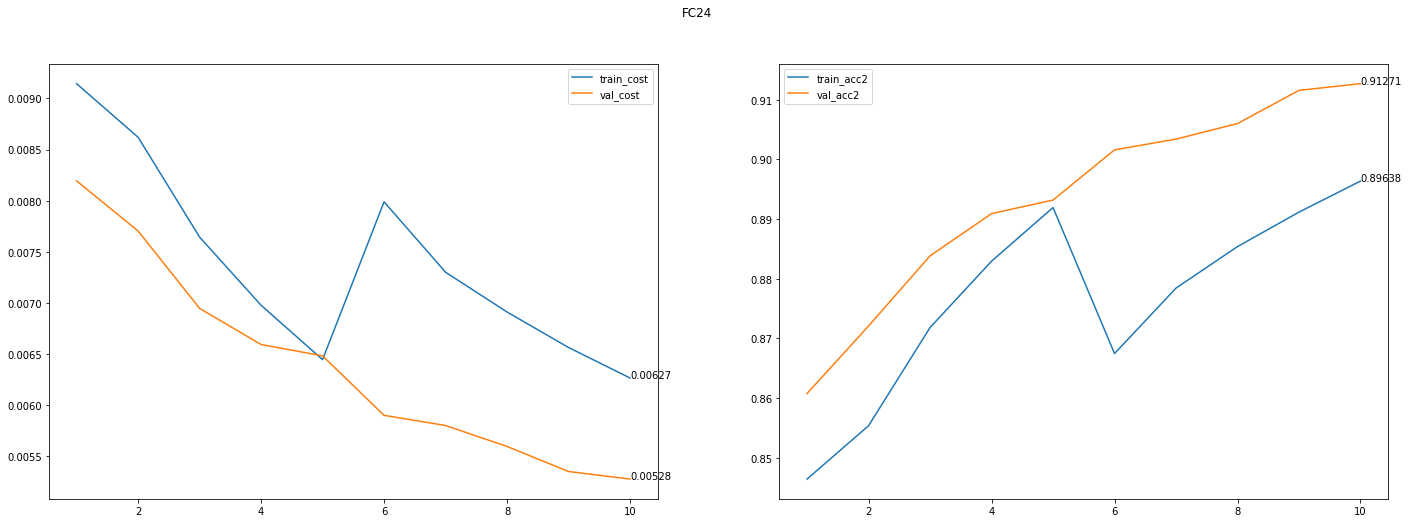

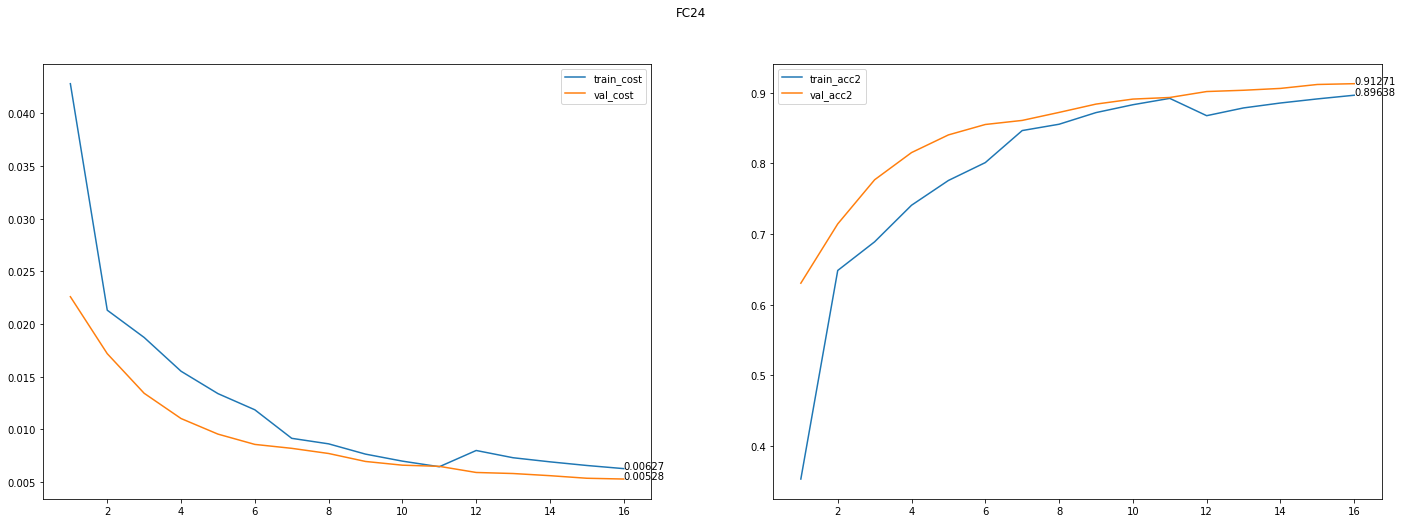

cuda available
(0.005251873259576375, 0.9131253957748413)


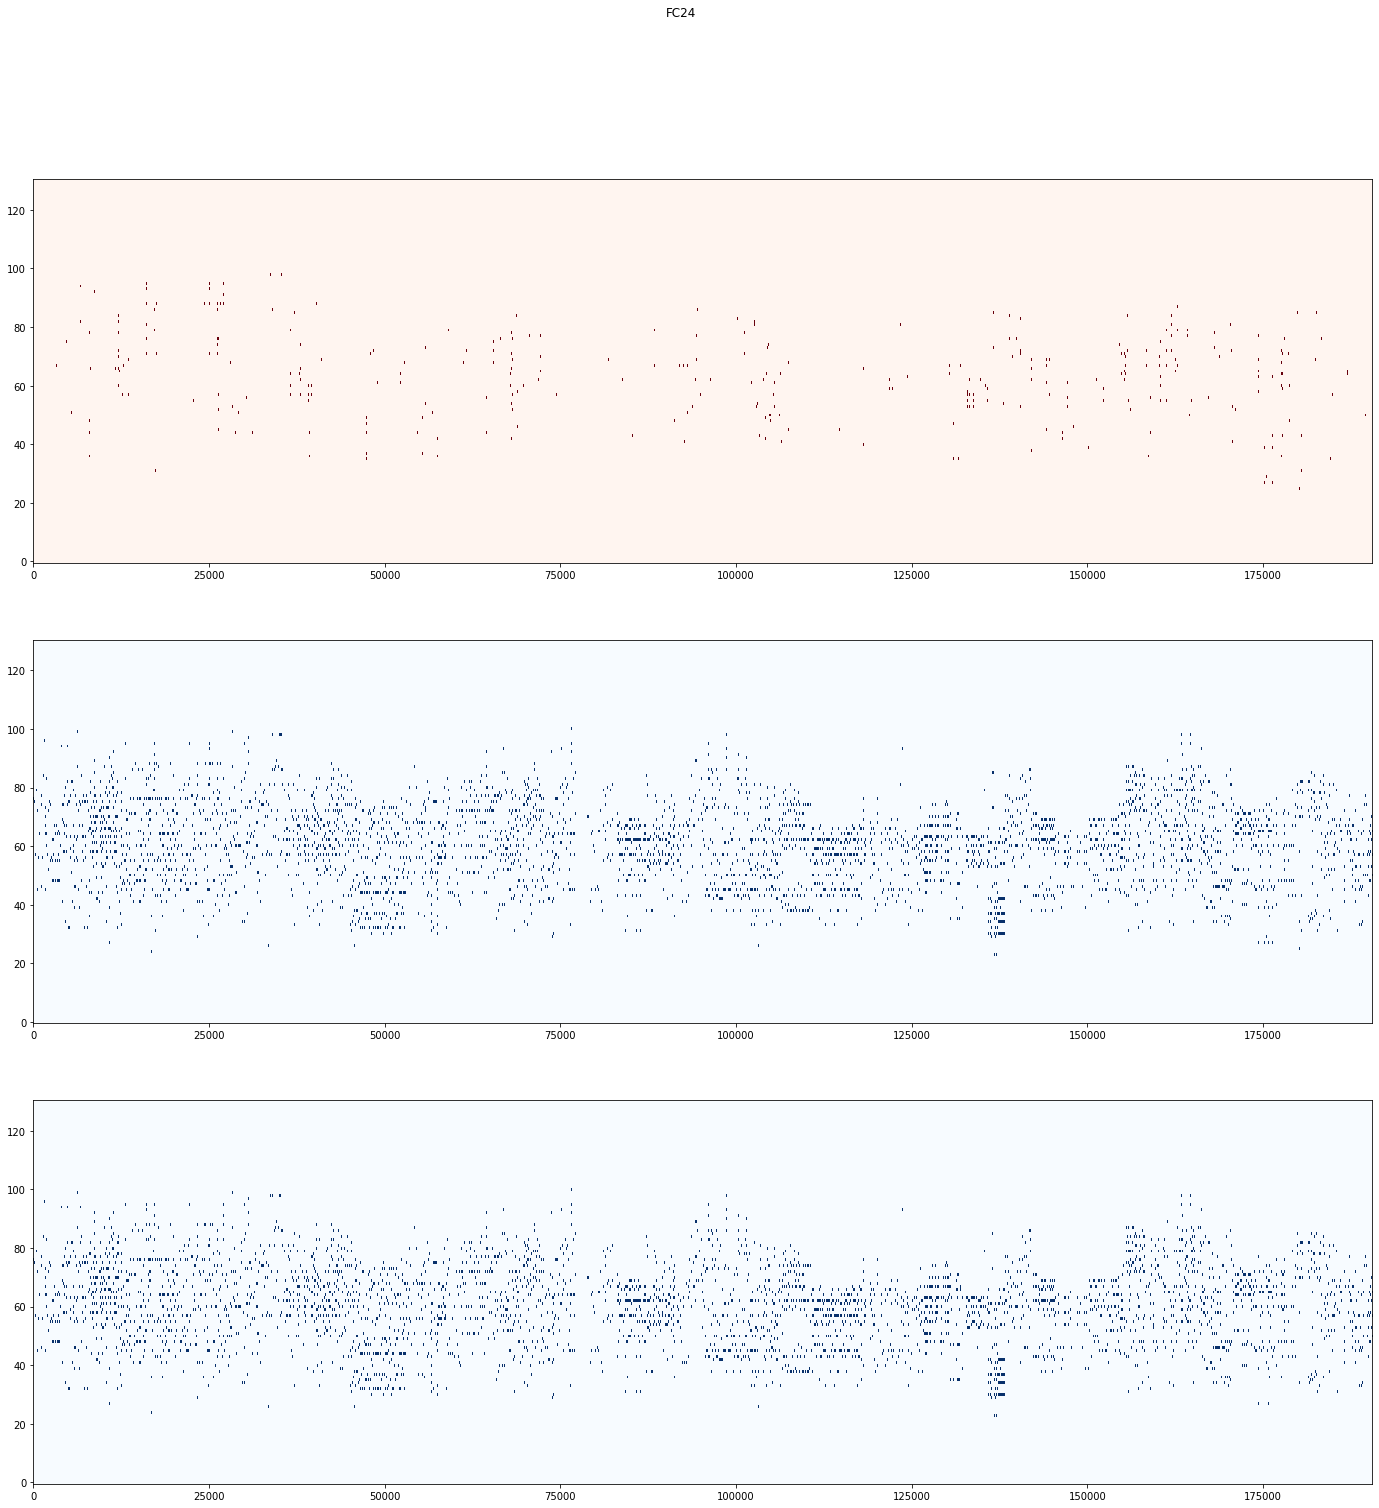

In [13]:
# run model
model_info={
    "model":FC24,
    "dataset":FCD2,
    "lr":0.001,
    "batch_size":256,
    "n_fft":2048,
    "hop_length":512,
    "is_shuffle":True,
    "model_version":102,
    "model_prev":101 
}
# path = "/content/drive/MyDrive/samples/Aimoz/"
foler_list = ["piano+0","piano+1","piano+2","piano+n"]
fs = 44100
dataset_version = 10
epochs = 10

if __name__ == "__main__":
    # load data_loader
    data_loaders = FC_loadDataloader(path,dataset_version,model_info)

    # run and visualize
    model_path = path + "/train/FCN/model/"
    # FC_train(model_path, model_info,data_loaders,epochs)
    VI_trainResult(model_path+"performance/",model_info, model_info["model"].__name__)
    VI_MultiTrainResult(model_path+"performance/",model_info, model_info["model"].__name__,[100,101,102])

    # test and visualize
    test_result = FC_test(model_path, model_info,data_loaders)
    VI_testResult(data_loaders,test_result,model_info["model"].__name__)  
        
        
        